In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import output_processing as op

/Users/ab-purushothama-macbook/.conda/envs/prej-prompt/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Multiple Tokens - Sum

In [47]:
model_list = [
    # Main set of models with instruct divide and size variety
    "meta-llama/Llama-3.2-1B",
    "meta-llama/Llama-3.2-1B-Instruct",
    "meta-llama/Llama-3.2-3B",
    "meta-llama/Llama-3.2-3B-Instruct",
    "meta-llama/Llama-3.1-8B",
    "meta-llama/Llama-3.1-8B-Instruct",
    # Small reference model - would allow for pretraining variation
    "gpt2-medium",
    # Other open models
    "allenai/OLMo-2-1124-7B",
    "allenai/OLMo-2-1124-7B-Instruct",
    "mistralai/Ministral-8B-Instruct-2410",
    "google/gemma-7b",
    "google/gemma-7b-it"
]
def read_and_organize_model_results(model_name):
    model_results = pd.read_csv(f"runs/runs-42_07_16/{model_name}-results.csv")
    model_results.replace([0.0], -65504, inplace=True)

    candidates = ['Yes', 'yes', 'No', 'no', 'A', 'B']
    yes_candidates = ['Yes', 'yes']
    # Raw logprob
    # Sum(p(yi...yb))
    no_candidates = ['No', 'no']
    # Raw logprob
    # Sum(p(yi...yb))
    
    model_results["yes_probs"] = np.sum([model_results[candidate + "_probs"] for candidate in yes_candidates], axis=0)
    model_results["no_probs"] = np.sum([model_results[candidate + "_probs"] for candidate in no_candidates], axis=0)
    
    model_results = op.organize_distribution(model_results)
    model_results["model_name"] = model_name.split("/")[-1]
    model_results.loc[model_results["Covered"] == True, "Judgment"] = "Covered"
    model_results.loc[model_results["Covered"] == True, "Judgment_prob"] = model_results["Covered_prob"]
    model_results.loc[model_results["NotCovered"] == True, "Judgment"] = "NotCovered"
    model_results.loc[model_results["NotCovered"] == True, "Judgment_prob"] = model_results["NotCovered_prob"]
    print(model_name, model_results.output.value_counts())
    return model_results
    
combined_results = [read_and_organize_model_results(model_name) for model_name in model_list]
combined_df = pd.concat(combined_results).reset_index()
combined_df.loc[:, "item"] = combined_df["title"] + ["version"]
combined_df.shape

meta-llama/Llama-3.2-1B output
yes       565
"         256
B         164
A         112
Yes        85
it         47
Harper      7
No          6
Name: count, dtype: int64
meta-llama/Llama-3.2-1B-Instruct output
yes    766
B      267
No     162
        17
\n      11
Yes     10
A        9
Name: count, dtype: int64
meta-llama/Llama-3.2-3B output
yes    844
B      260
no     114
A       14
No       7
C        2
\n       1
Name: count, dtype: int64
meta-llama/Llama-3.2-3B-Instruct output
yes    820
B      259
No      92
no      48
A       17
\n       6
Name: count, dtype: int64
meta-llama/Llama-3.1-8B output
yes    789
B      184
no     177
A       92
Name: count, dtype: int64
meta-llama/Llama-3.1-8B-Instruct output
no     617
yes    272
B      226
No      67
A       50
Yes     10
Name: count, dtype: int64
gpt2-medium output
yes      578
no       250
A        202
"        138
B         69
Genie      4
No         1
Name: count, dtype: int64
allenai/OLMo-2-1124-7B output
yes        556
no      

(14904, 28)

In [48]:
combined_df.to_csv("reports/combined-results_07_10.csv", index=False)

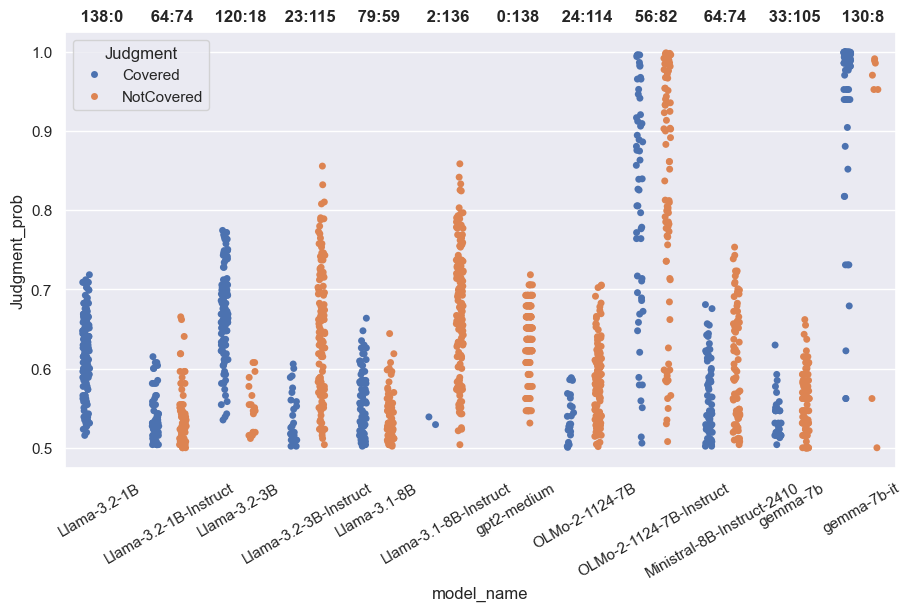

In [49]:
# Difference
# Plot
# 1. For each model we plot the difference between the normalized probability
# 2. Some models don't stick to script and are apparent here
                                 
                                  
fig, ax = plt.subplots(figsize=(9,6), layout='constrained')
plt.xticks(rotation=30)
sns.set_theme(style="darkgrid")

prompt_type_mask = combined_df["prompt_type"] == "yes_or_no"
data_df = combined_df[prompt_type_mask]

covered_mask = data_df["Judgment"] == "Covered"
not_covered_mask = data_df["Judgment"] == "NotCovered"
count_labels = data_df.groupby('model_name', as_index=False, sort=False).aggregate(
    {
        'Covered': 'sum',
        'NotCovered': 'sum',
    }
)
p = sns.stripplot(x='model_name', y='Judgment_prob',  hue='Judgment', jitter=True, dodge=True, data=data_df)

# p = sns.swarmplot(x='model_name', y='Judgment_prob',  hue='Judgment',  data=data_df, size=1)
# Labels showing proportions

for i, counts in enumerate(zip(count_labels.Covered.values, count_labels.NotCovered.values)): 
    covered = counts[0]
    not_covered = counts[1]
    ax.text(i, ax.get_ylim()[1] + 0.01, f' {covered}:{not_covered}', 
        ha='center', va='bottom', fontweight='bold')

# Greedy output

In [50]:
candidates = ['Yes', 'yes', 'No', 'no', 'A', 'B']
non_candidates = combined_df[combined_df.output.apply(lambda x: x.strip() not in candidates)]

In [51]:
non_candidates.shape

(805, 28)

In [52]:
non_candidates.prompt_type.value_counts()

prompt_type
options                  156
yes_or_no                155
options_flipped          137
no_or_yes                135
negation                 126
agreement_negation        92
disagreement               3
disagreement_negation      1
Name: count, dtype: int64

In [53]:
non_candidates.model_name.value_counts()

model_name
Llama-3.2-1B                  310
gemma-7b-it                   271
gpt2-medium                   142
gemma-7b                       29
Llama-3.2-1B-Instruct          28
Llama-3.2-3B-Instruct           6
OLMo-2-1124-7B                  6
Ministral-8B-Instruct-2410      5
OLMo-2-1124-7B-Instruct         5
Llama-3.2-3B                    3
Name: count, dtype: int64

In [54]:
non_candidates.shape, combined_df.shape

((805, 28), (14904, 28))

In [55]:
non_candidates.output.value_counts()

output
 "            394
\n\n          271
 it            47
               24
 \n            18
 Genie         10
 Harper         7
 Charlotte      6
 Miranda        6
 [              4
 **             3
 Margot         3
 C              2
 Cooper         2
 Carol          2
 Shannon        2
 Penelope       2
 \n\n           1
 Denise         1
Name: count, dtype: int64

In [56]:
non_candidates.to_csv("reports/non_candidate_samples.csv")